## Starting my own model

In [1]:
import pandas as pd
import pickle
from gensim.models.phrases import Phrases, Phraser

In [2]:
import time

In [3]:
import multiprocessing

from gensim.models import Word2Vec

In [4]:
from sqlitedict import SqliteDict

In [5]:
from datetime import datetime


In [8]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [9]:
cores

16

In [10]:
parameters = dict(min_count=3,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

### Google Model

In [5]:
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin'
google_model = KeyedVectors.load_word2vec_format(filename, binary=True)

KeyboardInterrupt: 

## Community Models

In [2]:
with open(f"control_brief_cleaning_2019", "rb") as fp:  # Pickling
    brief = pickle.load(fp)

In [7]:
pua_clean = SqliteDict("PUA _clean.sqlite", tablename="value", flag="r")

In [11]:
sub_sent = []
c = 0
for value in pua_clean.values():
    if(value["text"] != None):
        sub_sent.append(value["text"].split())

sub_phrases = Phrases(sub_sent, min_count=3)
sub_bigram = Phraser(sub_phrases)
sub_sentences = sub_bigram[sub_sent]

print("Start model")

Model = Word2Vec(**parameters)
Model.build_vocab(sub_sentences)

Start model


In [8]:
from gensim.models import KeyedVectors

pua_model = KeyedVectors.load("Alt-right_wordvectors_2010.kv", mmap='r')

In [9]:
pua_model.most_similar("man")

[('woman', 0.853803277015686),
 ('boy', 0.7841507196426392),
 ('girl', 0.7267001867294312),
 ('person', 0.7147223949432373),
 ('malnourish', 0.7113591432571411),
 ('treat_like', 0.7010998725891113),
 ('victim', 0.6975375413894653),
 ('mueller', 0.688467800617218),
 ('charle', 0.6859316825866699),
 ('white_man', 0.6825860738754272)]

In [12]:
Model.train(sub_sentences, total_examples=Model.corpus_count, epochs=30)

(1164392, 3052230)

In [12]:
print(Model.get_latest_training_loss())


6963471.5


In [44]:
for i in range(5):
    #Model.build_vocab(sub_sentences, update=True)
    Model.train(sub_sentences, total_examples=Model.corpus_count, epochs=5, compute_loss=True)
    print(Model.get_latest_training_loss())


336363.1875
336500.34375
337976.40625
337798.78125
335843.65625


In [14]:
Model.wv.most_similar("man")

[('man_mindfulattraction', 0.9792893528938293),
 ('need_coach', 0.9789830446243286),
 ('org_coach', 0.9785630702972412),
 ('bootcamp_https', 0.9769427180290222),
 ('interested_personal', 0.9767565131187439),
 ('coaching', 0.7946670055389404),
 ('skype', 0.7602478861808777),
 ('blind', 0.7561122179031372),
 ('shroom', 0.7555925250053406),
 ('alex', 0.7547237277030945)]

In [13]:
#Model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)
Model.train(sub_sentences, total_examples=Model.corpus_count, epochs=1)

#Model.init_sims(replace=True)
Model.save(f"pua2.model")
print(f"pua2.model saved")

pua2.model saved


In [14]:
Model.most_similar("man")

/home/grad/ccomp/19/emanuelsilva/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('s', 0.9999611377716064),
 ('woman', 0.9999599456787109),
 ('want', 0.9999518394470215),
 ('good', 0.9999498128890991),
 ('girl', 0.9999492168426514),
 ('like', 0.9999448657035828),
 ('people', 0.9999445676803589),
 ('guy', 0.9999445676803589),
 ('way', 0.9999443292617798),
 ('don_t', 0.9999436140060425)]

In [6]:
pua_model = Word2Vec.load("pua2.model")

In [8]:
pua_model.wv.most_similar("man")

[('s', 0.9999611377716064),
 ('woman', 0.9999599456787109),
 ('want', 0.9999518394470215),
 ('good', 0.9999498128890991),
 ('girl', 0.9999492168426514),
 ('like', 0.9999448657035828),
 ('people', 0.9999445676803589),
 ('guy', 0.9999445676803589),
 ('way', 0.9999443292617798),
 ('don_t', 0.9999436140060425)]

In [14]:
pua_model.train(sub_sentences, total_examples=pua_model.corpus_count, epochs=30)

(1164452, 3052230)

In [15]:
pua_model.wv.most_similar("man")

[('man_mindfulattraction', 0.9787890315055847),
 ('org_coach', 0.9781192541122437),
 ('need_coach', 0.9768918752670288),
 ('bootcamp_https', 0.9761693477630615),
 ('interested_personal', 0.9759275913238525),
 ('weak', 0.8123353719711304),
 ('coaching', 0.803511381149292),
 ('recognize', 0.7992246747016907),
 ('masculine', 0.7967274188995361),
 ('moral', 0.7943316102027893)]

## Time models

In [10]:
def time_model_creation(model_sqlite, community):
    
    models = []
    years = [2019, 2018, 2017, 2013, 2011, 2010, 2009, 2016, 2015, 2014, 2012, 2008, 2007]
    d = dict()
    sub = community
    year_sqlite = SqliteDict(f"{community}_years.sqlite", tablename="value", flag="r")
    
    """for value in model_sqlite.values():
        dt_object = datetime.fromtimestamp(value["timestamp"]//1000)
        
        if dt_object.year not in years:
            d[dt_object.year] = []
            years.append(dt_object.year)
            
        if value["text"] != None:
            d[dt_object.year].append(value["text"].split())

    print(years)
    
    for key, value in d.items():
        year_sqlite[key] = value
        
    year_sqlite.commit()"""
        
    for year in years:

        time_sent = year_sqlite[year]
        
        if len(time_sent) == 0:
            print(f"year {year} not found")
            continue
            
        time_phrases = Phrases(time_sent, min_count=3)
        time_bigram = Phraser(time_phrases)
        time_sentences = time_bigram[time_sent]
       
        with open(f"./../topic_model/data/{sub}_sentences_{year}.txt", "wb") as fp:  # Pickling
            pickle.dump(time_sentences, fp)
        print(f'{sub}_sentences_{year}.txt created')
        
        # Creating time Model
        Model = Word2Vec(**parameters)
        Model.build_vocab(time_sentences)
        Model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)
        Model.train(time_sentences, total_examples=Model.corpus_count, epochs=30)
        
        Model.init_sims(replace=True)
        Model.wv.save(f"{sub}_wordvectors_{year}.kv")
        
        models.append(Model)
        
        print(f"Created {sub}_wordvectors_{year}.kv")

In [11]:
time_model_creation(pua_clean, "left")

left_sentences_2019.txt created
Created left_wordvectors_2019.kv
left_sentences_2018.txt created
Created left_wordvectors_2018.kv
left_sentences_2017.txt created
Created left_wordvectors_2017.kv
left_sentences_2013.txt created
Created left_wordvectors_2013.kv
left_sentences_2011.txt created
Created left_wordvectors_2011.kv
left_sentences_2010.txt created
Created left_wordvectors_2010.kv
left_sentences_2009.txt created
Created left_wordvectors_2009.kv
left_sentences_2016.txt created
Created left_wordvectors_2016.kv
left_sentences_2015.txt created
Created left_wordvectors_2015.kv
left_sentences_2014.txt created
Created left_wordvectors_2014.kv
left_sentences_2012.txt created
Created left_wordvectors_2012.kv
left_sentences_2008.txt created
Created left_wordvectors_2008.kv
left_sentences_2007.txt created
Created left_wordvectors_2007.kv


## Comparing community models

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
sns.set()

In [8]:
def make_graph(model, word):
    G = nx.Graph()
    G.add_node(word)
    
    for close_word in model.most_similar(positive=[word], topn=5):
        close_word=close_word[0]
        G.add_node(close_word)
        G.add_edge(word, close_word)
        G[word][close_word]['weight'] = model.similarity(word, close_word) * 1000
        
        for other_word in model.most_similar(positive=[close_word], topn=3):
            other_word = other_word[0]
            G.add_node(other_word)
            G.add_edge(close_word, other_word)
            G[close_word][other_word]['weight'] = model.similarity(close_word, other_word) * 1000
    return G

* Cos similarity multiplied by 1000 to improve Fruchterman-Reingold force-directed algorithm

In [9]:
def comparing_models(models, word, titles=['First 1%', 'Last 1%'],
                     seed=6, rows=2, cols=2, suptitle='Reddit Communities'):

    Gs = [make_graph(model, word) for model in models]

    nr_rows = rows
    nr_cols = cols
    
    fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*8,nr_rows*4), squeeze=False)
    plt.suptitle(suptitle, y=0.95, fontsize=15)

    for r in range(0,nr_rows):
        for c in range(0, nr_cols):  
            col = r*nr_cols+c
            if col < len(models):
                color = ['yellow']
                color.extend(['skyblue']*(len(Gs[col].nodes)-1))
                
                axs[r][c].set(title=titles[col])
                nx.draw(Gs[col], pos=nx.spring_layout(Gs[col], seed=seed), with_labels=True,
                        node_color = color, font_size=12, ax=axs[r][c])


In [10]:
def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [11]:
def print_similar(models, word, model_names=["MR", "Incel", "MGTOW", "RedPill", "Google"], n=10, comparing="Reddit"):
    d = {}
    for i in range(len(models)):
        t = models[i].most_similar(positive=[word], topn=n)
        d[model_names[i]] = [t[j][0] for j in range(n)]
        
    df = pd.DataFrame(d)
    print(f'Words most similar to {word} on {comparing}')
    return df

In [12]:
def plot_cossim(word1, word2, models, communities=["MR", "Incel", "MGTOW", "RedPill"], comparing="Reddit"):
    x = communities
    y = [model.similarity(word1, word2) for model in models]
    fig, ax = plt.subplots()
    ax.set(title=(f'Cossim between {word1} and {word2} on {comparing}'))
    sns.pointplot(x, y, ax=ax);

In [13]:
def google_cossim(word1, word2, models, google_model, communities=["MR", "Incel", "MGTOW", "RedPill"], comparing="reddit"):
    x = communities
    y1 = [cos_sim(model.__getitem__(word1), google_model.__getitem__(word1)) for model in models]
    y2 = [cos_sim(model.__getitem__(word2), google_model.__getitem__(word2)) for model in models]
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    ax[0].set(title=(f'Cossim of {word1} between google and {comparing}'))
    sns.pointplot(x, y1, ax=ax[0]);
    ax[1].set(title=(f'Cossim of {word2} between google and {comparing}'))
    sns.pointplot(x, y2, ax=ax[1]);

In [14]:
def print_multy_similar(models_list, word, model_names=["MR", "Incel", "MGTOW", "RedPill", "Google"], years=['2017'], n=10, comparing="Reddit"):
    for i in range(len(models_list)):
        display(print_similar(models_list[i], word, n=n, model_names=years, comparing=model_names[i]))
        print("\n")

In [17]:
from gensim.models import KeyedVectors

pua_model = KeyedVectors.load("pua_wordvectors.kv", mmap='r')
alt_r_model = KeyedVectors.load("Alt-right_wordvectors.kv", mmap="r")
center_model = KeyedVectors.load("center_wordvectors.kv", mmap="r")
l_center_model = KeyedVectors.load("left-center_wordvectors.kv", mmap="r")
left_model = KeyedVectors.load("left_wordvectors.kv", mmap="r")
r_center_model = KeyedVectors.load("rigth-center_wordvectors.kv", mmap="r")

FileNotFoundError: [Errno 2] No such file or directory: 'left-center_wordvectors.kv'

#### Table of most similar words 

In [63]:
word = 'woman'
n = 10
models = [pua_model]
print_similar(models, word, n=n, comparing='Alt Righters Reddits')

Words most similar to woman on Alt Righters Reddits


,MR
0,man
1,teenage_girl
2,fall_love
3,feel_secure
4,female
5,take_advantage
6,someone
7,teenager
8,upper_hand
9,high_value


#### Cos Similarity between two words in each community

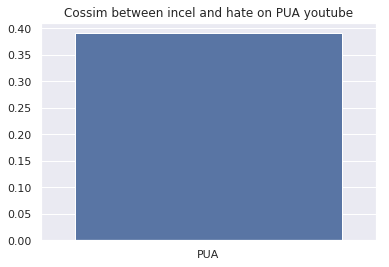

In [58]:
word1 = 'incel'
word2 = 'hate'
models = [pua_model]
plot_cossim(word1, word2, models, communities=["PUA"], comparing="PUA youtube")

#### Cos Similarity between word in each community and in google (how much that word changes)

* Words used rarely change less than frequently used words

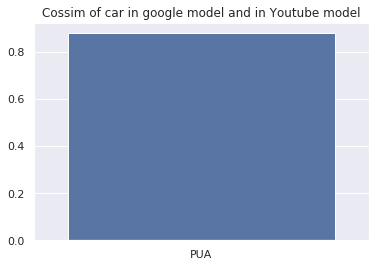

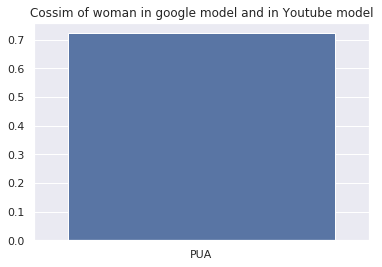

In [65]:
word1 = 'car'
word2 = 'woman'
models = [pua_model]
google_cossim(word1, models, google_model, communities=["PUA"], comparing="Youtube")
google_cossim(word2, models, google_model, communities=["PUA"], comparing="Youtube")


#### Graph of closest words for each community

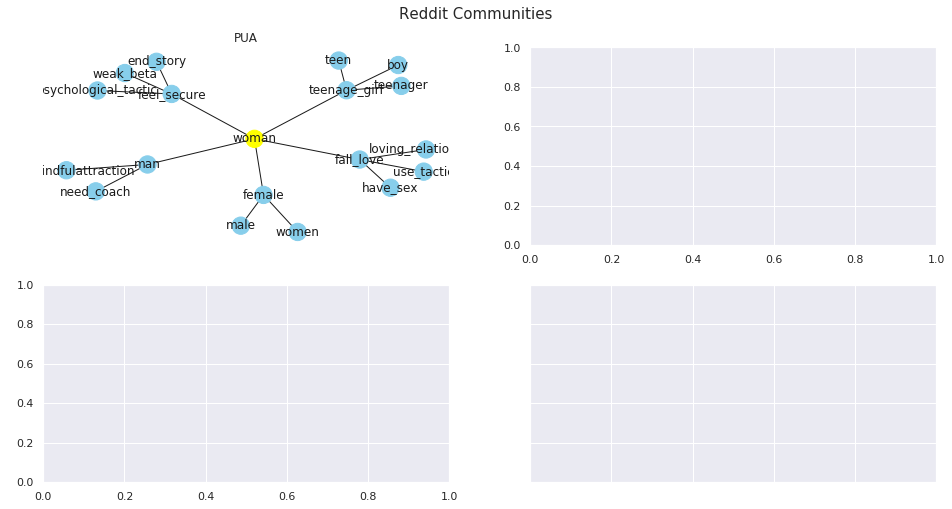

In [66]:
word = 'woman'
comparing_models(models, word, titles=["PUA"])

## Comparing time models

In [15]:
from gensim.models import KeyedVectors

years = [i for i in range(2010, 2020)]

In [19]:
years_str = list(map(str, years))

In [20]:
years_str

['2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019']

In [21]:
alt_r_models = []
for year in years:
    alt_r_models.append(KeyedVectors.load(f"Alt-right_wordvectors_{year}.kv", mmap='r'))
    
center_models = []
for year in years:
    center_models.append(KeyedVectors.load(f"center_wordvectors_{year}.kv", mmap='r'))
    
l_center_models = []
for year in years:
    l_center_models.append(KeyedVectors.load(f"left-center_wordvectors_{year}.kv", mmap='r'))
    
left_models = []
for year in years:
    left_models.append(KeyedVectors.load(f"left_wordvectors_{year}.kv", mmap='r'))
    
r_center_models = []
for year in years:
    r_center_models.append(KeyedVectors.load(f"rigth-center_wordvectors_{year}.kv", mmap='r'))

#### Tables of most similar words by time for each community

In [22]:
word = "woman"

In [23]:
all_models = [alt_r_models, center_models, l_center_models, left_models, r_center_models]
names = ["Alt-right", "center", "left-center", "left", "right-center"]

In [43]:
print_multy_similar(models_list=all_models, word="woman", model_names=names, n=5, years=years)

Words most similar to woman on Alt-right


,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,man,girl,man,man,man,man,man,man,man,man
1,girl,man,girl,female,girl,women,girl,girl,female,female
2,mother,lady,white_man,girl,women,male,traditional_woman,male,male,girl
3,lady,mother,child,elderly,female,female,women,people,girl,male
4,boy,boy,female,male,law_protect,rape_black,child,female,child,child




Words most similar to woman on center


,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,women,women,man,man,man,man,man,man,man,man
1,force_wear,abuse_child,feminist,female,female,girl,women,people,girl,girl
2,muslim_woman,single_mother,male,child,child,people,girl,child,people,person
3,wear_burqa,man,female,male,girl,female,prostitute,person,person,people
4,female,pregnant,women,feminist,feminist,male,believe_gender,girl,female,child




Words most similar to woman on left-center


,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,man,man,man,man,man,man,man,man,man,man
1,teenage_girl,girl,girl,girl,child,women,girl,person,girl,girl
2,girl,women,lesbian,child,girl,person,person,people,female,lady
3,housewife,person,teenage_girl,person,women,girl,people,girl,lady,female
4,women,teenage_girl,men,sexual_pleasure,person,femininity,man_woman,child,person,person




Words most similar to woman on left


,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,woman_funny,man,man,man,man,man,man,man,man,man
1,need_funny,female,women,opposite_sex,woman_funny,girl,girl,female,female,girl
2,man,attractive_woman,woman_funny,woman_funny,female,attract_man,female,girl,male,female
3,attract_man,woman_funny,attract_man,large_breast,women,men,people,male,girl,lady
4,woman_attractive,funny_woman,woman_attractive,attract_man,male_female,women,male,person,lady,person




Words most similar to woman on right-center


,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,girl,man,man,man,man,man,man,man,man,man
1,man,lady,man_woman,person,female,women,women,girl,girl,girl
2,lady,start_fight,husband,male,women,male,female,women,lady,lady
3,mother,women,scorici,girl,male,girl,man_woman,lady,child,people
4,prostitute,girl,women,female,girl,gender,girl,man_woman,female,child


#### Cos Similarity of two words over time

The google similarity is:  0.09995703


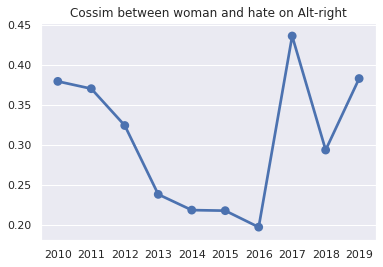

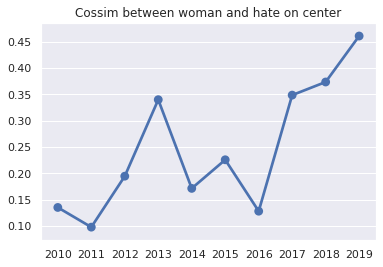

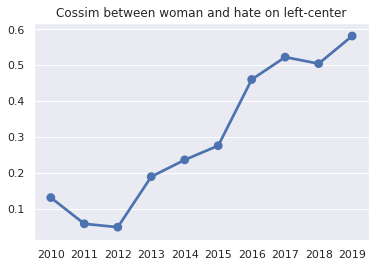

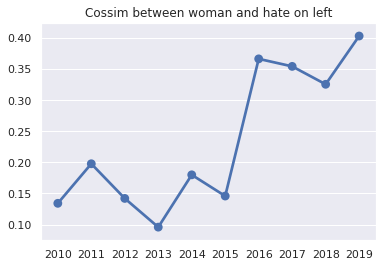

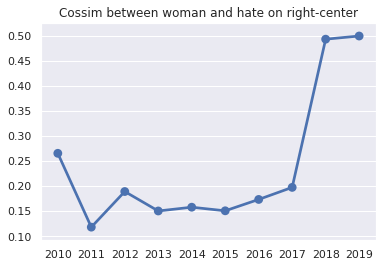

In [80]:
word1 = 'woman'
word2 = 'hate'
print("The google similarity is: ", cos_sim(google_model.__getitem__(word1), google_model.__getitem__(word2)))
for i in range(len(all_models)):
    plot_cossim(word1, word2, all_models[i], communities=years_str, comparing=names[i])

#### Cos Similarity between a word in community model and google model by time (how much this word has changed over time)

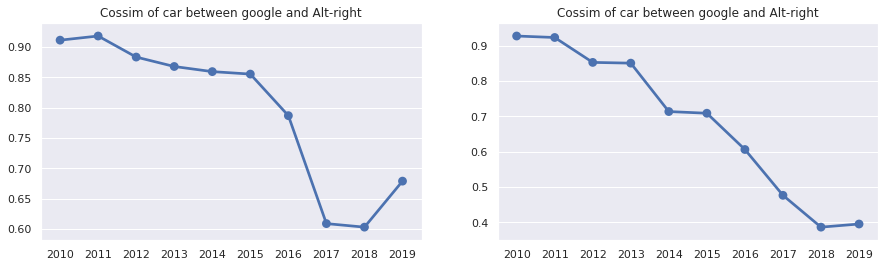

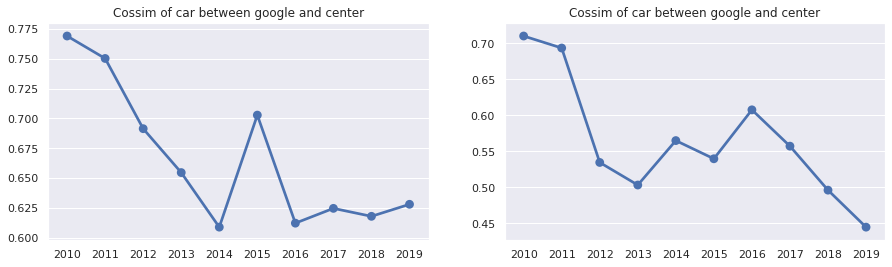

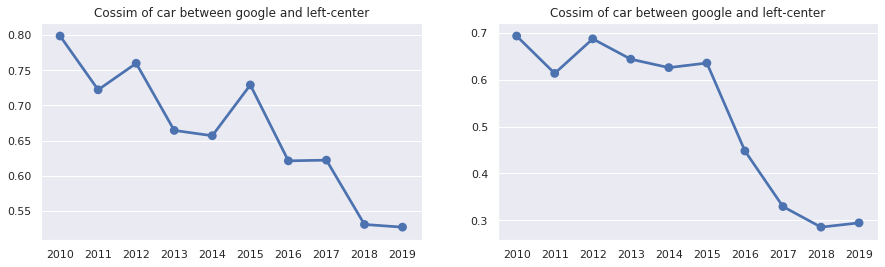

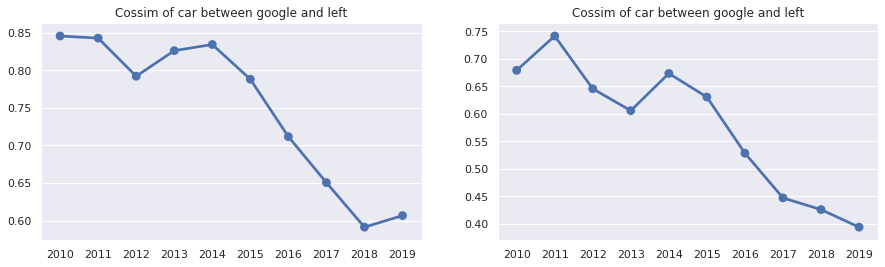

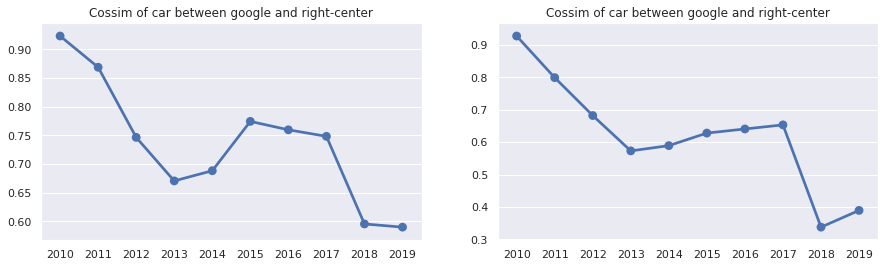

In [77]:
for i in range(len(all_models)):
    google_cossim('car', 'woman', all_models[i], google_model, communities=years_str, comparing=names[i])

#### Graph of closest words over time

In [81]:
word = 'man'

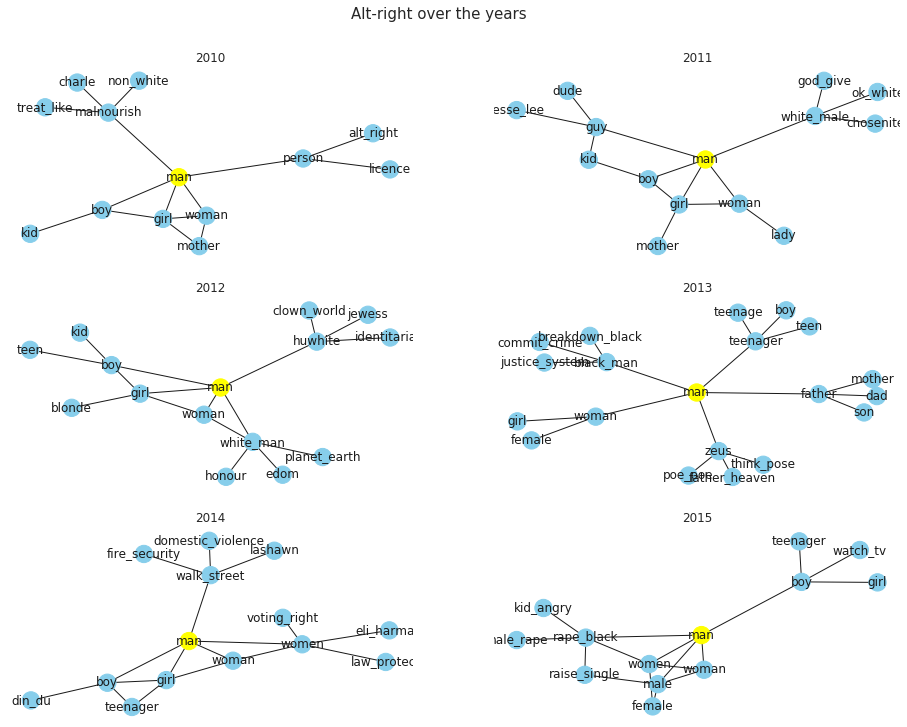

In [83]:
comparing_models(all_models[0], word, titles=years_str, rows=3, cols=2, suptitle=f'{names[0]} over the years')

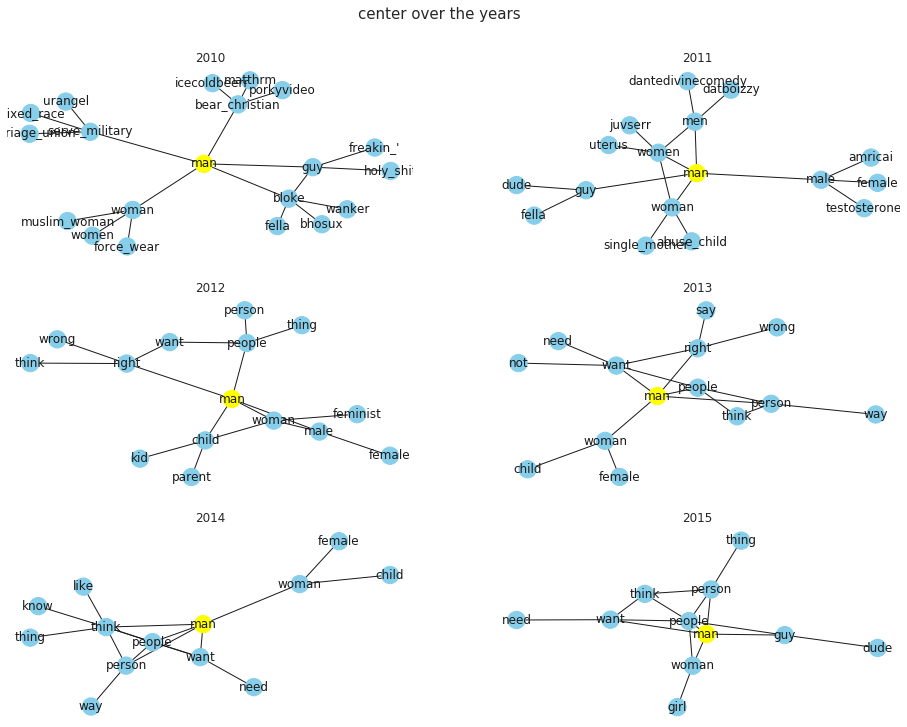

In [84]:
comparing_models(all_models[1], word, titles=years_str, rows=3, cols=2, suptitle=f'{names[1]} over the years')

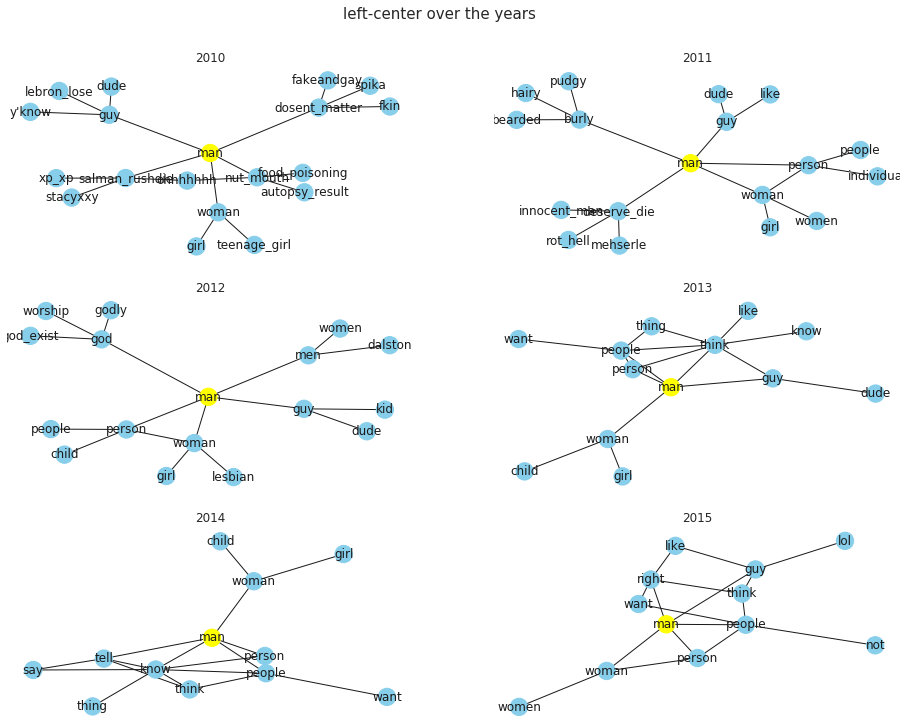

In [85]:
comparing_models(all_models[2], word, titles=years_str, rows=3, cols=2, suptitle=f'{names[2]} over the years')

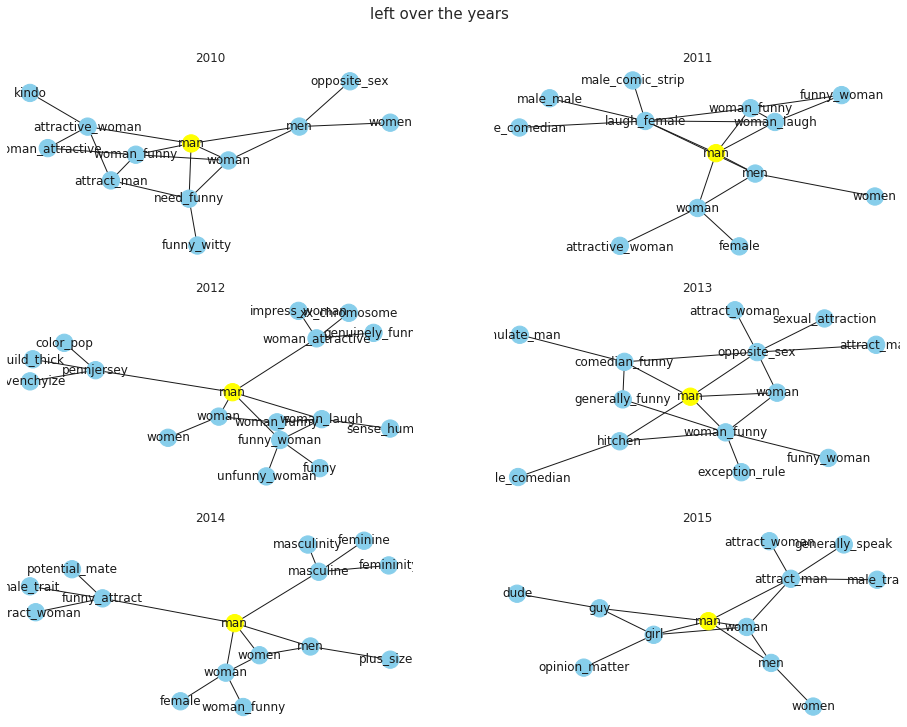

In [86]:
comparing_models(all_models[3], word, titles=years_str, rows=3, cols=2, suptitle=f'{names[3]} over the years')

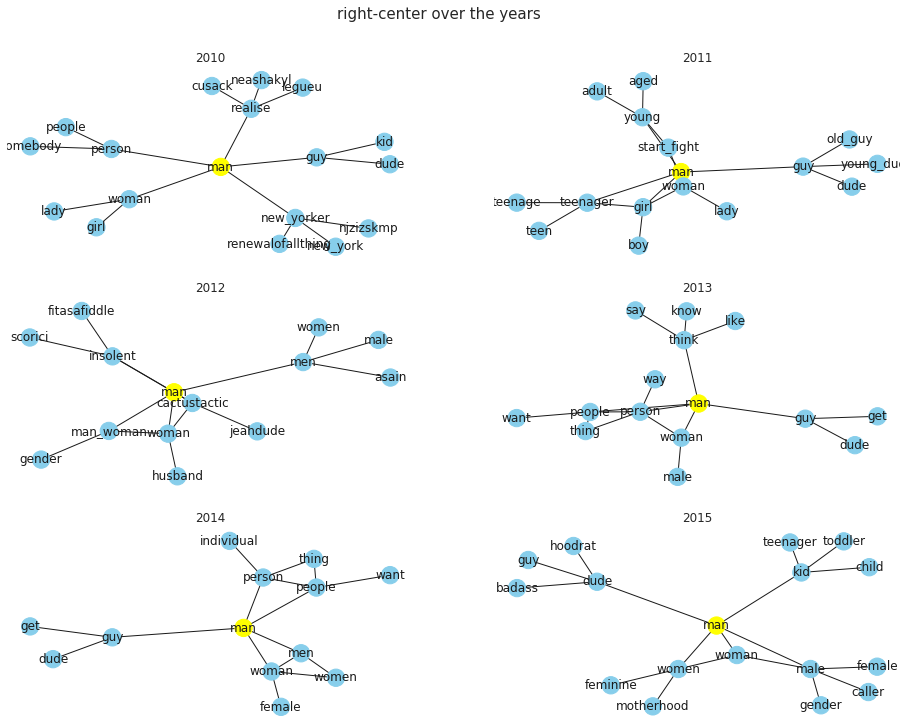

In [87]:
comparing_models(all_models[4], word, titles=years_str, rows=3, cols=2, suptitle=f'{names[4]} over the years')

# WEAT

In [6]:
import itertools
import numpy as np

In [7]:
def Cos(w1, w2, model):
    #print(f"Cossim {w1}, {w2}", test.similarity(w1, w2))
    return model.similarity(w1, w2)

In [8]:
def s_word(w, A1, A2, model):
    return np.mean([Cos(w, a, model) for a in A1]) - np.mean([Cos(w, b, model) for b in A2])

In [9]:
def s_group(C1, C2, A1, A2, model):
    return np.sum([s_word(x, A1, A2, model) for x in C1]) - np.sum([s_word(y, A1, A2, model) for y in C2])

In [10]:
def d(C1, C2, A1, A2, model):
    return ((np.mean([s_word(x, A1, A2, model) for x in C1])
            - np.mean([s_word(y, A1, A2, model) for y in C2]))
            / np.std([s_word(w, A1, A2, model) for w in C1+C2]))

In [11]:
def permutations(C1, C2):
    X = []
    Y = []
    for permutation in itertools.combinations(C1+C2, len(C1)):
        X.append(permutation)
        y = []
        for element in C1+C2:
            if element not in permutation:
                y.append(element)
        Y.append(y)
    return X, Y

In [12]:
def p_value(C1, C2, A1, A2, model):
    s = s_group(C1, C2, A1, A2, model)
    X, Y = permutations(C1, C2)
    c = 0
    for i in range(len(X)):
        if(s_group(X[i], Y[i], A1, A2, model)>s):
            c+=1
    return(c/len(X))

In [13]:
def WEAT(cls_attr, topics, model, name="Google"):
    t = []
    for i in range(len(topics)):
        C1 = cls_attr[i][0]
        C2 = cls_attr[i][1]
        A1 = cls_attr[i][2]
        A2 = cls_attr[i][3]

        s = s_group(C1, C2, A1, A2, model)
        cohen_d = d(C1, C2, A1, A2, model)
        p = p_value(C1, C2, A1, A2, model)

        print(f"For {topics[i]} Topic at {name}:\nAssociation s = {s:.3f}, \
        \nCohen's d = {cohen_d:.3f}, \np_value = {p:.3f}")
        print()
        t.append([cohen_d, p])
    return(t)
    

In [22]:
#LGBT
C1_LGBT = ["gay", "homosexual", "bisexual"]
C2_LGBT = ["straight", "heterosexual", "het"]
A1_LGBT = ["sinner", "promiscuous", "immoral", "outrageous"]
A2_LGBT = ["moral", "normal", "natural"]
CA_LGBT = [C1_LGBT, C2_LGBT, A1_LGBT, A2_LGBT]

#Muslism
C1_MUS = ["islam", "mohammed", "muslim", "quran"]
C2_MUS = ["bible", "christian", "christianity", "jesus"]
A1_MUS = ["assassin", "attack", "bomb", "death", "murder", "radical", "terrorist"]
A2_MUS = ["compassionate", "gentle", "humane", "kind", "tolerant"]
CA_MUS = [C1_MUS, C2_MUS, A1_MUS, A2_MUS]

#Immigrants
C1_IMI = ["immigrant", "migrant"]
C2_IMI = ["citizen", "native"]
A1_IMI = ["bad", "burden", "pirate", "plague", "taker", "thief"]
A2_IMI = ["good", "honest", "maker", "rightful"]
CA_IMI = [C1_IMI, C2_IMI, A1_IMI, A2_IMI]

CA = [CA_LGBT, CA_MUS, CA_IMI]
topics = ["LGBT", "Muslisms", "Immigrants"]

In [15]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
from gensim.models import KeyedVectors

#alt_r_model = KeyedVectors.load("Alt-right_wordvectors.kv", mmap="r")

In [21]:
test = google_model

NameError: name 'google_model' is not defined

For LGBT Topic at Google:
Association s = 0.348,         
Cohen's d = 1.521, 
p_value = 0.000

For Muslisms Topic at Google:
Association s = 0.194,         
Cohen's d = 1.550, 
p_value = 0.014

For Immigrants Topic at Google:
Association s = 0.166,         
Cohen's d = 1.841, 
p_value = 0.000



In [17]:
WEAT(CA, topics)

TypeError: WEAT() missing 1 required positional argument: 'model'

In [26]:
*community

SyntaxError: can't use starred expression here (<ipython-input-26-dc50756661e3>, line 4)

For LGBT Topic at right-center:
Association s = 0.156,         
Cohen's d = 0.583, 
p_value = 0.271

For Muslisms Topic at right-center:
Association s = 0.245,         
Cohen's d = 1.049, 
p_value = 0.100

For Immigrants Topic at right-center:
Association s = 0.120,         
Cohen's d = 0.894, 
p_value = 0.333


In [33]:
community = 3*["Google"]+ 3*["Alt-right"] +3*["Center"] + 3*["Left-center"]
topics=4*["LGBT", "MUS", "IMI"]
cohen_d=[1.521,1.550,  1.841, 1.250, 1.459, 1.777, 1.408,1.022,1.857, 1.607, 1.007, 1.861]
p_value = [0.000, 0.014,  0.000, 0.057, 0.014, 0.000,  0.043, 0.071,  0.000, 0.014, 0.100, 0.000]
df = pd.DataFrame({"Community":community, "Topic":topics, "Cohen's D":cohen_d, "p_value":p_value})

In [34]:
df

,Community,Topic,Cohen's D,p_value
0,Google,LGBT,1.521,0.000
1,Google,MUS,1.550,0.014
2,Google,IMI,1.841,0.000
3,Alt-right,LGBT,1.250,0.057
4,Alt-right,MUS,1.459,0.014
5,Alt-right,IMI,1.777,0.000
6,Center,LGBT,1.408,0.043
7,Center,MUS,1.022,0.071
8,Center,IMI,1.857,0.000
9,Left-center,LGBT,1.607,0.014


In [35]:
import seaborn as sns
sns.set()

In [36]:
[df.p_value>0.001]

[0     False
 1      True
 2     False
 3      True
 4      True
 5     False
 6      True
 7      True
 8     False
 9      True
 10     True
 11    False
 Name: p_value, dtype: bool]

In [37]:
markers = []
for val in df.p_value:
    if val>0.1:
        markers.append("p>0.1")
    elif val>0.05:
        markers.append("0.1>p>0.05")
    else:
        markers.append("p<0.05")

In [45]:
df[3:]

,Community,Topic,Cohen's D,p_value
3,Alt-right,LGBT,1.250,0.057
4,Alt-right,MUS,1.459,0.014
5,Alt-right,IMI,1.777,0.000
6,Center,LGBT,1.408,0.043
7,Center,MUS,1.022,0.071
8,Center,IMI,1.857,0.000
9,Left-center,LGBT,1.607,0.014
10,Left-center,MUS,1.007,0.100
11,Left-center,IMI,1.861,0.000


In [39]:
import matplotlib.pyplot as plt

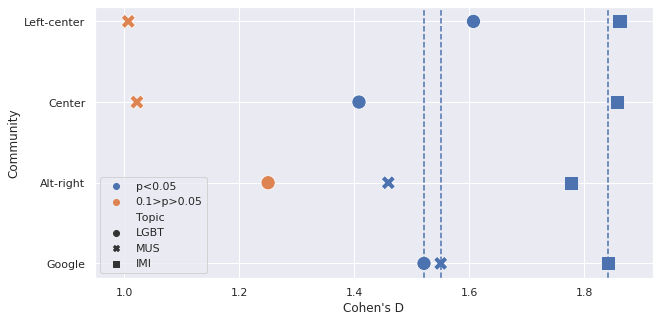

In [48]:
plt.figure(figsize=[10, 5])
sns.scatterplot(y="Community", x="Cohen's D", style="Topic",sizes=np.full(9, 100), data=df, hue=markers[3:],
                markers=["o", "X", "s"], s=200)
plt.axvline(x=1.521, linestyle='--')
plt.axvline(x=1.550, linestyle='--')
plt.axvline(x=1.841, linestyle='--');

In [18]:
WEAT(CA, topics, model=alt_r_model)

For LGBT Topic at Google:
Association s = 0.271,         
Cohen's d = 1.250, 
p_value = 0.057

For Muslisms Topic at Google:
Association s = 0.527,         
Cohen's d = 1.459, 
p_value = 0.014

For Immigrants Topic at Google:
Association s = 0.266,         
Cohen's d = 1.777, 
p_value = 0.000



For LGBT Topic at Google:<br>
Association s = 0.348,<br>
Cohen's d = 1.521, <br>
p_value = 0.000<br>
<br>
For Muslisms Topic at Google:<br>
Association s = 0.194,         <br>
Cohen's d = 1.550, <br>
p_value = 0.014<br>
<br>
For Immigrants Topic at Google:<br>
Association s = 0.166,         <br>
Cohen's d = 1.841, <br>
p_value = 0.000<br>

For LGBT Topic at Alt-right:<br>
Association s = 0.271,<br>
Cohen's d = 1.250,<br>
p_value = 0.057<br>
<br>
For Muslisms Topic at Alt-right:<br>
Association s = 0.527,         <br>
Cohen's d = 1.459, <br>
p_value = 0.014<br>
<br>
For Immigrants Topic at Alt-right:<br>
Association s = 0.266,         <br>
Cohen's d = 1.777, <br>
p_value = 0.000<br>



For LGBT Topic at Center:<br>
Association s = 0.276,<br>
Cohen's d = 1.408,<br> 
p_value = 0.043<br>
<br>
For Muslisms Topic at Center:<br>
Association s = 0.197,<br>
Cohen's d = 1.022,<br> 
p_value = 0.071<br>
<br>
For Immigrants Topic at Center:<br>
Association s = 0.118,<br>
Cohen's d = 1.857,<br> 
p_value = 0.000<br>

In [47]:
center_model = KeyedVectors.load("Alt-right_wordvectors_2019.kv", mmap="r")


In [23]:

names = ["Alt-right", "Intellectual Dark Web", "Alt-lite", "control"]

for i in range(len(topics)):
    cohen = []
    pval = []
    comm = []
    y = []
    for name in names:
        print(name)
        for year in [2017, 2018, 2019]:
            model = KeyedVectors.load(f"./../../../tmp_w2v/{name}_wordvectors_{year}.kv", mmap="r")
            r = WEAT([CA[i]], [topics[i]], model=model, name=f"{name} {year}")
            cohen.append(r[0][0])
            pval.append(r[0][1])
            comm.append(name)
            y.append(year)
    di ={}
    di["bias"] = cohen
    di["pval"] = pval
    di["community"] = comm
    di["year"] = y
    df = pd.DataFrame(di)
    df.to_csv(f"./weat/{topics[i]}_weat.csv")

Alt-right
For LGBT Topic at Alt-right 2017:
Association s = -0.027,         
Cohen's d = -0.132, 
p_value = 0.500

For LGBT Topic at Alt-right 2018:
Association s = 0.113,         
Cohen's d = 1.784, 
p_value = 0.000

For LGBT Topic at Alt-right 2019:
Association s = 0.241,         
Cohen's d = 1.648, 
p_value = 0.000

Intellectual Dark Web
For LGBT Topic at Intellectual Dark Web 2017:
Association s = 0.144,         
Cohen's d = 1.965, 
p_value = 0.000

For LGBT Topic at Intellectual Dark Web 2018:
Association s = 0.245,         
Cohen's d = 1.828, 
p_value = 0.000

For LGBT Topic at Intellectual Dark Web 2019:
Association s = 0.023,         
Cohen's d = 0.159, 
p_value = 0.400

Alt-lite
For LGBT Topic at Alt-lite 2017:
Association s = 0.275,         
Cohen's d = 1.718, 
p_value = 0.000

For LGBT Topic at Alt-lite 2018:
Association s = 0.190,         
Cohen's d = 1.440, 
p_value = 0.050

For LGBT Topic at Alt-lite 2019:
Association s = 0.039,         
Cohen's d = 0.314, 
p_value = 0.35

In [36]:
markers = []
for val in df.pval:
    if val>0.1:
        markers.append("p>0.1")
    else:
        markers.append("p<0.05")
df["markers"] = markers

In [62]:
years = ["2016-2017", "2018", "2019"]

In [25]:
df

,bias,pval,community,year,markers
0,1.646733,0.000000,Alt-right,2017,p<0.05
1,1.830848,0.000000,Alt-right,2018,p<0.05
2,1.860570,0.000000,Alt-right,2019,p<0.05
3,1.279274,0.166667,Intellectual Dark Web,2017,p>0.1
4,1.710357,0.000000,Intellectual Dark Web,2018,p<0.05
5,0.933409,0.166667,Intellectual Dark Web,2019,p>0.1
6,1.271526,0.166667,Alt-lite,2017,p>0.1
7,1.790754,0.000000,Alt-lite,2018,p<0.05
8,1.659822,0.000000,Alt-lite,2019,p<0.05
9,1.686746,0.000000,control,2017,p<0.05


In [37]:
lines = ['-', '--', '-.', ':', '-', '-.', ':']

In [38]:
from matplotlib.legend import Legend
import seaborn as sns

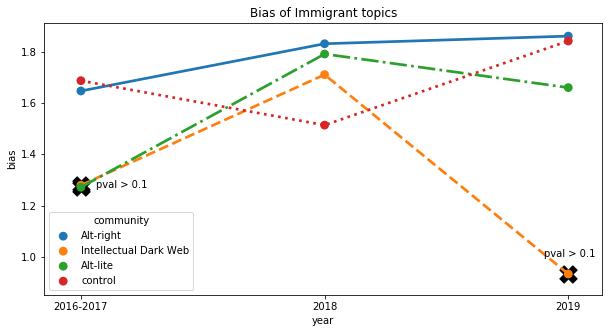

In [66]:
df = pd.read_csv(f"./weat/Immigrants_weat.csv")

plt.figure(figsize=[10, 5])
plt.title("Bias of Immigrant topics")
sns.pointplot(y="bias", x="year", style="markers", data=df, hue="community",
                linestyles=lines, legend_out=False)
plt.xticks(ticks = [0, 1, 2], labels=years)
for row in df.iterrows():
    if row[1]["pval"] > 0.1:
        plt.scatter(x=row[1]["year"]-2017, y=row[1]["bias"], s=300, marker="X", c="k")
plt.text(1.9,1, "pval > 0.1");
plt.text(.06, 1.27, "pval > 0.1");
plt.savefig("./weat/Immigrant_bias.png")

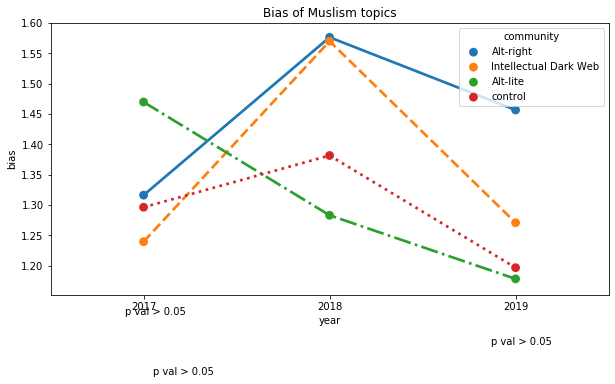

In [44]:
df = pd.read_csv(f"./weat/Muslisms_weat.csv")
plt.figure(figsize=[10, 5])
plt.title("Bias of Muslism topics")
sns.pointplot(y="bias", x="year", style="markers", data=df, hue="community",
                linestyles=lines, legend_out=False)
for row in df.iterrows():
    if row[1]["pval"] > 0.1:
        plt.scatter(x=row[1]["year"]-2017, y=row[1]["bias"], s=300, marker="X", c="k")

plt.savefig("./weat/Muslism_bias.png")

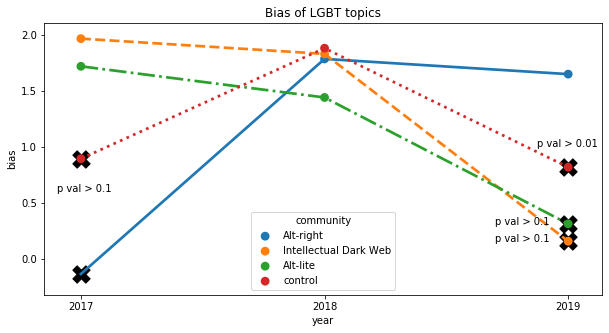

In [54]:
df = pd.read_csv(f"./weat/LGBT_weat.csv")
plt.figure(figsize=[10, 5])
plt.title("Bias of LGBT topics")
sns.pointplot(y="bias", x="year", style="markers", data=df, hue="community",
                linestyles=lines, legend_out=False)
for row in df.iterrows():
    if row[1]["pval"] > 0.1:
        plt.scatter(x=row[1]["year"]-2017, y=row[1]["bias"], s=300, marker="X", c="k")
plt.text(1.87,1.0, "p val > 0.01");
plt.text(-0.1, 0.6, "p val > 0.1");
plt.text(1.7, 0.309, "p val > 0.1");
plt.text(1.7, 0.15, "p val > 0.1");
plt.savefig("./weat/LGBT_bias.png")

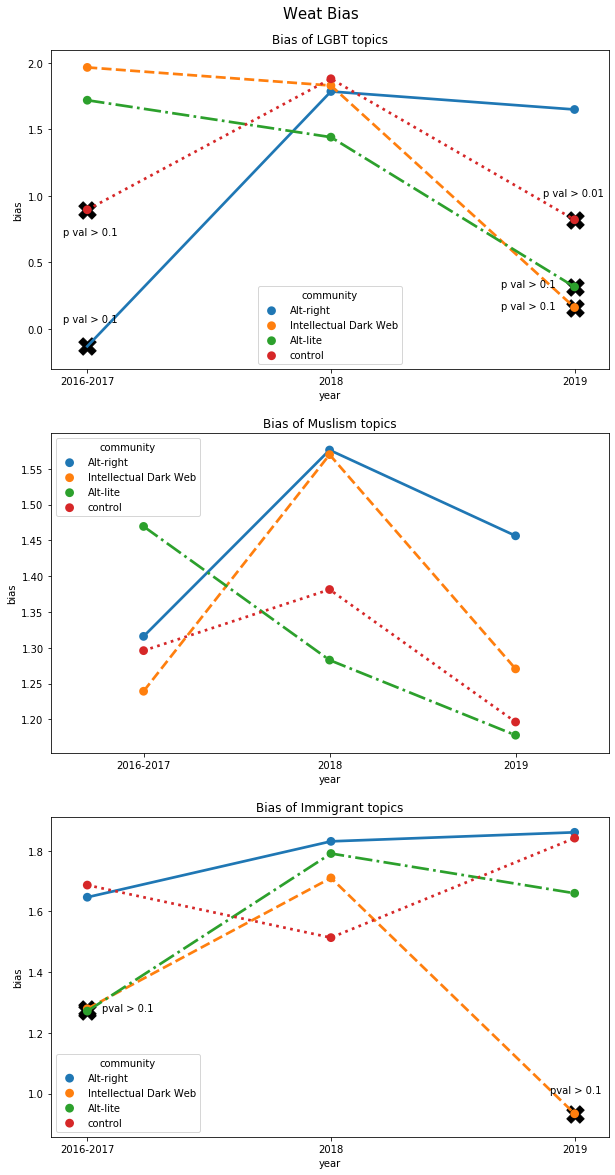

In [74]:
fig, axs = plt.subplots(3, 1, figsize=(10,20), squeeze=False)
plt.suptitle("Weat Bias", y=0.91, fontsize=15)
plt.xticks(ticks = [0, 1, 2], labels=years)

#LGBT
df = pd.read_csv(f"./weat/LGBT_weat.csv")
axs[0, 0].set_title("Bias of LGBT topics")
sns.pointplot(y="bias", x="year", style="markers", data=df, hue="community",
                linestyles=lines, legend_out=False, ax=axs[0, 0])
for row in df.iterrows():
    if row[1]["pval"] > 0.1:
        axs[0, 0].scatter(x=row[1]["year"]-2017, y=row[1]["bias"], s=300, marker="X", c="k")
    
axs[0, 0].text(1.87,1.0, "p val > 0.01");
axs[0, 0].text(-0.1, 0.7, "p val > 0.1");
axs[0, 0].text(-0.1, 0.05, "p val > 0.1");
axs[0, 0].text(1.7, 0.309, "p val > 0.1");
axs[0, 0].text(1.7, 0.15, "p val > 0.1");
axs[0, 0].set_xticklabels(years)

#MUSLISM
df = pd.read_csv(f"./weat/Muslisms_weat.csv")
axs[1, 0].set_title("Bias of Muslism topics")
sns.pointplot(y="bias", x="year", style="markers", data=df, hue="community",
                linestyles=lines, legend_out=False, ax=axs[1, 0])
axs[1, 0].set_xticklabels(years)

for row in df.iterrows():
    if row[1]["pval"] > 0.1:
        axs[1, 0].scatter(x=row[1]["year"]-2017, y=row[1]["bias"], s=300, marker="X", c="k")
    

#Immigrants
df = pd.read_csv(f"./weat/Immigrants_weat.csv")
axs[2, 0].set_title("Bias of Immigrant topics")
sns.pointplot(y="bias", x="year", style="markers", data=df, hue="community",
                linestyles=lines, legend_out=False, ax=axs[2, 0])
for row in df.iterrows():
    if row[1]["pval"] > 0.1:
        axs[2, 0].scatter(x=row[1]["year"]-2017, y=row[1]["bias"], s=300, marker="X", c="k")

axs[2, 0].set_xticklabels(years)
axs[2, 0].text(1.9,1, "pval > 0.1");
axs[2, 0].text(.06, 1.27, "pval > 0.1");


plt.savefig("./weat/WEAT_bias.png")